
# Evaluación de Compiladores (SLY + Python)

**Duración sugerida:** 2 horas  
**Entorno:** Python ≥ 3.10, `sly` (`pip install sly`)  
**Entrega:** ZIP con `lexer.py`, `parser.py`, `tests_*.py` (si aplica), `parsing.out` y `tabla_lalr.md/.xlsx`, más este notebook con las secciones completadas.

---



## Sección A — Análisis léxico (20 pts)

### A1. Tokens con SLY (12 pts)
Implemente un lexer que reconozca: `ID`, `INT`, `PLUS (+)`, `ASSIGN (:=)`, `LPAREN`, `RPAREN`, y las palabras reservadas `while`, `do`.

> Pruebe con la cadena: `while x do y := y + 1`


In [1]:

# A1. Esqueleto de lexer con SLY
# Ejecute esta celda, modifique si lo requiere.
# Guardará un archivo 'lexer.py' con el contenido del lexer.

from textwrap import dedent

lexer_code = dedent('''from sly import Lexer

class LexerSLY(Lexer):
    tokens = { ID, INT, PLUS, ASSIGN, WHILE, DO, LPAREN, RPAREN }
    ignore = ' \t'

    # Palabras reservadas via re-map sobre ID
    ID = r'[A-Za-z_][A-Za-z0-9_]*'
    ID = ID
    ID['while'] = 'WHILE'
    ID['do']    = 'DO'

    # Operadores y símbolos
    PLUS   = r'\+'
    ASSIGN = r':='
    LPAREN = r'\('
    RPAREN = r'\)'

    INT = r'\d+'

    # Comentarios de línea estilo //...
    ignore_comment = r'//.*'

    @_(r'\n+')
    def newline(self, t):
        self.lineno += t.value.count('\n')

    def error(self, t):
        # A2. Manejo simple de error léxico
        print(f'Illegal character {t.value[0]!r} at line {self.lineno}')
        self.index += 1

if __name__ == "__main__":
    data = "while x do y := y + 1"
    lx = LexerSLY()
    for tok in lx.tokenize(data):
        print(tok)
''')

with open('/mnt/data/lexer.py', 'w', encoding='utf-8') as f:
    f.write(lexer_code)

print("Archivo creado: /mnt/data/lexer.py")


<>:20: SyntaxWarning: invalid escape sequence '\+'
<>:20: SyntaxWarning: invalid escape sequence '\+'
/tmp/ipython-input-1532038073.py:20: SyntaxWarning: invalid escape sequence '\+'
  PLUS   = r'\+'


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/lexer.py'


### A2. Errores léxicos (8 pts)
Explique dos estrategias para manejar caracteres inesperados y deje implementada una en `LexerSLY.error`. Ejecute la prueba siguiente y observe el manejo de error.


In [ ]:

# Prueba de A1/A2 (opcional)
# Ejecuta el lexer sobre una cadena con un carácter ilegal '@'
import importlib, sys, types
sys.path.append('/mnt/data')
LexerModule = importlib.import_module('lexer')

lx = LexerModule.LexerSLY()
data = "x := 3 + @"
for tok in lx.tokenize(data):
    print(tok)



## Sección B — Expresiones regulares (15 pts)

### B3. Regex (9 pts)
Proponga regex y justificación breve para:
a) Identificadores que no comienzan por dígito y pueden contener dígitos.  
b) Números decimales con signo opcional y parte fraccionaria opcional (no se acepta solo '.').  
c) Comentarios de bloque `/* ... */` no anidados.

Escriba sus respuestas aquí:



**Respuesta B3:**  
a)  [a-zA-Z_][a-zA-Z0-9_]*
b)  ^[+-]?\d+(\.\d+)?$
c)  /*(.|\n)*?\*



### B4. Ambigüedad léxica (6 pts)
Explique cómo priorizar `ASSIGN (:=)` sobre `:` y `=` separados en el **lexer** (token más largo / maximal munch).  
Escriba su respuesta aquí:


**Respuesta B4:**

El analizador lexico suele dar prioridad al token mas largo, y en caso de empate, sería al que aparezca primero, en caso de := al ser el TOKEN mas largo, este se resolveria primero


## Sección C — LR(k): conceptos y construcción (20 pts)

### C5. Teoría (8 pts)
Defina y contraste **LR(0), SLR(1), LR(1), LALR(1)**.  
Indique: lookahead, practicidad y un ejemplo de conflicto donde SLR falla y LR(1) no.


**Respuesta C5:**


LR(0): El Impulsivo.
SLR(1): El Intuitivo.
LR(1): El mas preciso  (pero mas desgastante).
LALR(1): el estándar

SLR(1) falla porque su  decisión es demasiado general. Si un mismo token le sugiere dos acciones posibles, entra en conflicto porque no llega a saber cuál elegir.

LR(1) lo soluciona siendo muy específico. En lugar de una regla general, conoce el token exacto requerido para cada acción en ese contexto particular. Al ser las opciones dependientes de tokens distintos, no hay ambigüedad y siempre sabe qué hacer.




### C6. Ítems LR(0) y DFA (12 pts)

Gramática (añada `S' → S`):
```
S → S PLUS id
S → id
```
- Construya los conjuntos de ítems LR(0) y el DFA (I0, I1, ...).
- Indique dónde aparece conflicto **shift/reduce** si se usa **SLR(1)** (use FOLLOW para justificar).


**Respuesta C6 (ítems, DFA y análisis de conflicto):**

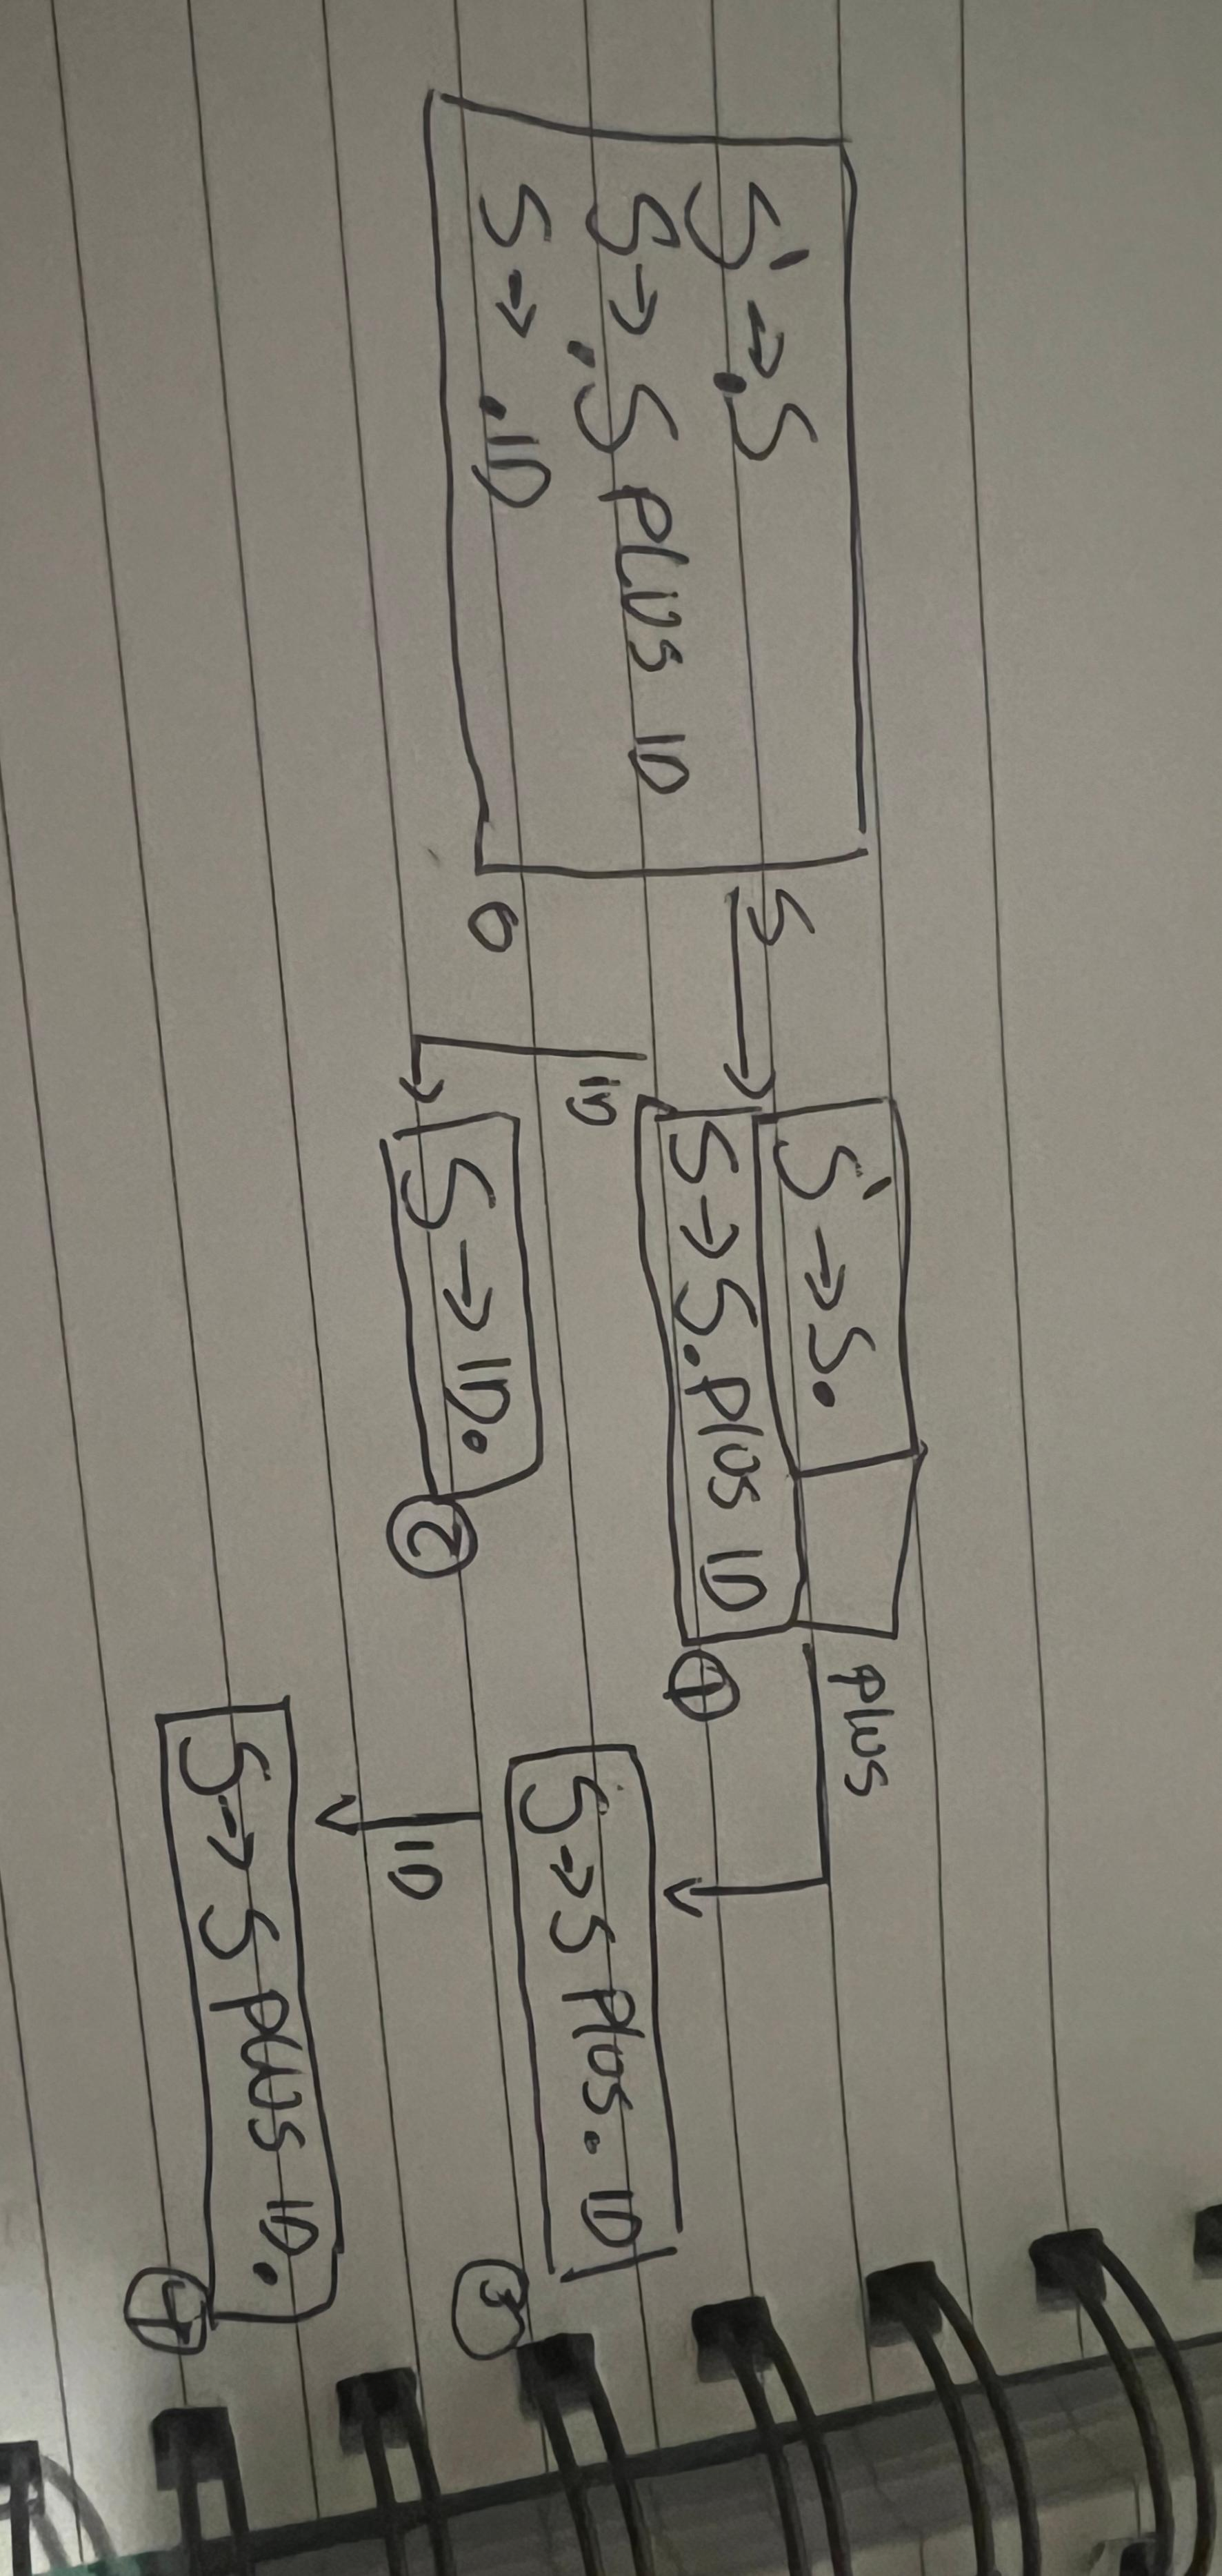

0. S' → S
1. S → S PLUS id
2. S → id

En la Tabla LALR

El autómata construido no presenta conflictos bajo las reglas de SLR(1).


## Sección D — FIRST y FOLLOW (15 pts)

Gramática:
```
E  → T E'
E' → PLUS T E' | ε
T  → id | LPAREN E RPAREN
```
- Calcule **FIRST** y **FOLLOW** de cada no terminal (E, E', T).  
- ¿Es LL(1)? ¿Apta para SLR(1)? Justifique brevemente.



**Tablas de FIRST/FOLLOW (complete):**

| NT | FIRST |
|----|-------|
| E  | `{ id, LPAREN }` |
| E' | `{ PLUS, ε }`    |
| T  | `{ id, LPAREN }` |

| NT | FOLLOW |
|----|--------|
| E  | `{ $, RPAREN }`      |
| E' | `{ $, RPAREN }`      |
| T  | `{ PLUS, $, RPAREN }` |

#### ¿Es Apta para SLR(1)?

**Sí, es apta para SLR(1).**

**Justificación:** Existe una relación jerárquica entre las gramáticas: toda gramática LL(1) es también SLR(1).


**Comentario LL(1)/SLR(1):**


## Sección E — SLY y tabla LALR(1) desde `debugfile` (30 pts)

Use **exactamente** esta gramática:
```
0) S → E $
1) E → WHILE E DO E
2) E → ID ASSIGN E
3) E → E PLUS E
4) E → ID
```


In [ ]:

# E8/E10. Esqueleto de parser con SLY con debugfile y precedencias sugeridas
# Esta celda escribe 'parser.py' en /mnt/data.
from textwrap import dedent

parser_code = dedent('''from sly import Parser
from lexer import LexerSLY

class ParserSLY(Parser):
    tokens = LexerSLY.tokens
    debugfile = 'parsing.out'   # SLY generará este archivo al construir el parser

    # E10. Ajuste la precedencia segun su análisis:
    # De menor a mayor: ASSIGN (derecha), luego PLUS (izquierda)
    precedence = (
        ('right', 'ASSIGN'),
        ('left',  'PLUS'),
    )

    # Símbolo inicial S
    @_('E')
    def S(self, p):
        return p.E

    @_('WHILE E DO E')
    def E(self, p):
        return ('while', p.E0, p.E1)

    @_('ID ASSIGN E')
    def E(self, p):
        return ('assign', p.ID, p.E)

    @_('E PLUS E')
    def E(self, p):
        return ('add', p.E0, p.E1)

    @_('ID')
    def E(self, p):
        return ('var', p.ID)

if __name__ == '__main__':
    lx = LexerSLY()
    ps = ParserSLY()
    # Leer desde stdin para forzar construcción y generar parsing.out
    import sys
    data = sys.stdin.read()
    result = ps.parse(lx.tokenize(data))
    print(result)
''')

with open('/mnt/data/parser.py', 'w', encoding='utf-8') as f:
    f.write(parser_code)

print("Archivo creado: /mnt/data/parser.py")



### E8. Generar `parsing.out`
Ejecute en una terminal (o desde aquí con `!python /mnt/data/parser.py` y pegue alguna entrada).  
Incluya el archivo `parsing.out` en su entrega.


In [ ]:

# (Opcional) Ejecutar parser para forzar creación de parsing.out
# Nota: Esta celda espera entrada estándar; puede modificar 'data' para automatizar.
import importlib, sys, io
sys.path.append('/mnt/data')
from lexer import LexerSLY
from parser import ParserSLY

lx = LexerSLY()
ps = ParserSLY()

data = "while x do y := y + x"
result = ps.parse(lx.tokenize(data))
print("Resultado ejemplo:", result)
print("Si el backend de SLY escribe 'parsing.out', quedará junto a 'parser.py' al importar/construir el parser.")



### E9. Reconstruir la tabla LALR(1)
Copie desde `parsing.out` los **estados**, **ACTION** (shift/reduce/accept) por token y **GOTO** por no terminal.
Use la siguiente plantilla y añada filas/columnas según sea necesario.



**Plantilla de tabla (llene con datos de `parsing.out`):**

| Estado | `ID` | `WHILE` | `DO` | `PLUS` | `$` | `ASSIGN` | **GOTO E** |
|-------:|:----:|:-------:|:----:|:-----:|:---:|:--------:|:----------:|
| I0     |      |         |      |       |     |          |            |
| I1     |      |         |      |       |     |          |            |
| ...    |      |         |      |       |     |          |            |

- **Conflictos**: anote celdas con formatos como `s5 / r3` y enumere qué producción corresponde.



### E10. Resolución de conflictos por precedencia/asociatividad
Indique para cada conflicto si elige **shift** o **reduce** para obtener la precedencia convencional:  
- `ASSIGN` (:=) **más débil** que `PLUS` (+).  
- `PLUS` **asociativo a la izquierda**.  
- `ASSIGN` **asociativo a la derecha**.

Explique en 5–8 líneas los cambios antes/después y re-genere la tabla.


**Respuesta E10 (antes/después):**


Antes

| Estado | ID | WHILE | DO | PLUS | $ | ASSIGN | GOTO E | GOTO S |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **I0** | s3 | s4 | | | | | 2 | 1 |
| **I1** | | | | | acc | | | |
| **I2** | | | | s5 | r1 | | | |
| **I3** | | | r2 | r2 | r2 | s6 | | |
| **I4** | s3 | s4 | | | | | 7 | |
| **I5** | s3 | s4 | | | | | 8 | |
| **I6** | s3 | s4 | | | | | 9 | |
| **I7** | | | s10 | s5 | | | | |
| **I8** | | | r3 | **s5/r3** | r3 | | | |
| **I9** | | | r4 | **s5/r4** | r4 | | | |
| **I10** | s3 | s4 | | | | | 11 | |
| **I11** | | | r5 | **s5/r5** | r5 | | | |

Después

| Estado | ID | WHILE | DO | PLUS | $ | ASSIGN | GOTO E | GOTO S |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **I0** | s3 | s4 | | | | | 2 | 1 |
| **I1** | | | | | acc | | | |
| **I2** | | | | s5 | r1 | | | |
| **I3** | | | r2 | r2 | r2 | s6 | | |
| **I4** | s3 | s4 | | | | | 7 | |
| **I5** | s3 | s4 | | | | | 8 | |
| **I6** | s3 | s4 | | | | | 9 | |
| **I7** | | | s10 | s5 | | | | |
| **I8** | | | r3 | **r3** | r3 | | | |
| **I9** | | | r4 | **s5** | r4 | | | |
| **I10** | s3 | s4 | | | | | 11 | |
| **I11** | | | r5 | **s5** | r5 | | | |


## Sección F — BONUS (+5 pts): AST mínimo y pruebas

Implemente acciones semánticas para construir nodos `Assign(id, expr)`, `Add(e1, e2)`, `While(cond, body)`, `Var(id)` y ejecute sobre:
- `x := 1 + 2`
- `while x do x := x + 1`


In [ ]:

# (Opcional) Ejemplo de evaluación / AST sencillo
# Puede adaptar estas funciones a sus nodos reales.
def pretty(ast):
    if isinstance(ast, tuple):
        tag, *xs = ast
        return f"{tag}(" + ", ".join(pretty(x) for x in xs) + ")"
    return repr(ast)

tests = [
    "x := 1 + 2",
    "while x do x := x + 1",
]

from lexer import LexerSLY
from parser import ParserSLY

lx = LexerSLY()
ps = ParserSLY()

for s in tests:
    r = ps.parse(lx.tokenize(s))
    print(s, "=>", pretty(r))



---

## Rúbrica (100 pts → escala 1–5)

| Criterio | Pts |
|---|---:|
| A1. Lexer SLY: tokens correctos, reservadas, pruebas | 12 |
| A2. Manejo de errores léxicos | 8 |
| B3. Regex correctas y justificadas | 9 |
| B4. Resolución ambigüedad `:=` vs `:` `=` | 6 |
| C5. Teoría LR(k) | 8 |
| C6. Ítems LR(0) y DFA; conflicto SLR | 12 |
| D7. FIRST/FOLLOW y comentario | 15 |
| E8. `parsing.out` generado | 6 |
| E9. Tabla LALR(1) reconstruida | 12 |
| E10. Precedencia/Asociatividad aplicada | 12 |
| BONUS F. AST/ejecución | +5 |
